In [45]:
!wandb login

wandb: Currently logged in as: shreyans (ai_in_pathology). Use `wandb login --relogin` to force relogin


# Image Segmentation: GI-Tract Scans

In [1]:
from fastai.vision.all import *
import numpy as np
import torch
import pandas as pd
import pdb
from tqdm.notebook import tqdm
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import time
from collections import defaultdict
import sklearn
import torchvision.transforms as transforms
import torch
from torch.utils.data import Dataset,DataLoader
import pdb
import wandb

In [2]:
train_df=pd.read_csv('train.csv')

In [3]:
train_df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [4]:
import time
from collections import defaultdict


class EventTimer():
    def __init__(self):
        ## if you stop an event (code block) without starting,
        ## it will show 0 for the time elapsed
        self.start_times=defaultdict(time.perf_counter)
        self.elapsed={}
        
    def start(self,event_name:str):
        self.start_times[event_name]=time.perf_counter()
        
    def stop(self, event_name:str):
        end =time.perf_counter()
        self.elapsed[event_name] = end - self.start_times[event_name]
        
timer=EventTimer()

In [5]:
all_imgs=get_image_files(Path('train'))

In [6]:
def filepath2id(fpath):
    _,_,caseid,_,sliceid=str(fpath).split('\\')
    ## join caseid and scanid with / to get the overall img_id
    id_lst=np.array([caseid])
    id_lst=np.concatenate((id_lst,sliceid.split('_')[:2]))
    return '_'.join(id_lst)

all_imgs_df=pd.DataFrame({'img_path':img_path,
                        'id':filepath2id(img_path)} for img_path in all_imgs)

In [7]:
all_imgs_df

,img_path,id
0,train\case101\case101_day20\scans\slice_0001_266_266_1.50_1.50.png,case101_day20_slice_0001
1,train\case101\case101_day20\scans\slice_0002_266_266_1.50_1.50.png,case101_day20_slice_0002
2,train\case101\case101_day20\scans\slice_0003_266_266_1.50_1.50.png,case101_day20_slice_0003
3,train\case101\case101_day20\scans\slice_0004_266_266_1.50_1.50.png,case101_day20_slice_0004
4,train\case101\case101_day20\scans\slice_0005_266_266_1.50_1.50.png,case101_day20_slice_0005
...,...,...
38491,train\case92\case92_day0\scans\slice_0140_266_266_1.50_1.50.png,case92_day0_slice_0140
38492,train\case92\case92_day0\scans\slice_0141_266_266_1.50_1.50.png,case92_day0_slice_0141
38493,train\case92\case92_day0\scans\slice_0142_266_266_1.50_1.50.png,case92_day0_slice_0142
38494,train\case92\case92_day0\scans\slice_0143_266_266_1.50_1.50.png,case92_day0_slice_0143


### Dataset

In [8]:
%%writefile 'RLE_Segmentation_Dataset_inference.py'

import sklearn
import torchvision.transforms as transforms
import torch
from torch.utils.data import Dataset,DataLoader
import pdb




## dataset class gto nload only X (images), to generate dataloaders for inference
class RLE_SegmentationDataset_inference(Dataset):
    def __init__(self,img_paths_df,  transform=transforms.Resize((224,224))
                 ):
        
        self.items=img_paths_df
        self.item_transform = transform
        
        
    def __len__(self):
        return len(self.items)
    
   
    def get_img_T(self,img_path):
        img_t=TensorImage(Image.open(img_path))
        H,W=img_t.shape
        if self.item_transform:
            img_t = self.item_transform(img_t.unsqueeze(0))
            
        return img_t.to(torch.float32) ,H,W                        
    
    def __getitem__(self, idx):
        
        item_data=self.items.iloc[idx]
        img_path,img_id=item_data['img_path'],item_data['id']
        img_t,H,W=self.get_img_T(img_path)
        
       ## return 3 channel image to put it through the fastai_model
        return img_t*torch.ones((3,1,1))
    
    
## dataset class to load both X and Y (for training)  - modify only __getitem__ method
class RLE_SegmentationDataset_train(Dataset):
    
    def __init__(self,img_paths_df, label_df=pd.read_csv('train.csv'), item_transform=transforms.Resize((224,224)), 
                 target_transform=transforms.Resize((224,224))):
        
        self.items=img_paths_df
        self.inference_ds=RLE_SegmentationDataset_inference(img_paths_df,item_transform)
        self.img_labels_df=label_df
        self.target_transform = target_transform
        self.codes={'background':0,'small_bowel':3,'large_bowel':2,'stomach':1}
        
        
        
    def __len__(self):
        return len(self.items)
    
    
    def get_mask_T(self,img_id,H,W):
        
        label_data=self.img_labels_df[self.img_labels_df['id']==img_id]
        label_data=label_data[label_data['segmentation'].notnull()]
         #Incase of no segmentation rle encoding, assert that every pixel belongs to the background
        if len(label_data)==0:
            mask_t=torch.zeros((H,W))
        else: 
            ## in case of overlap b/w pixels of different classes in labels,assign to
            ## smallest class in order small_bowel<large_bowel<stomach
            mask_t=torch.Tensor(np.stack([self.rle2mask(rle_pixels,H,W)*self.codes[pxl_cls] 
                                    for pxl_cls,rle_pixels in 
              zip(label_data['class'],label_data['segmentation'])]).max(axis=0))
        if self.target_transform:
            mask_t = TensorMask(self.target_transform(mask_t.unsqueeze(0)).squeeze(0).to(torch.int64))
          
        return mask_t   
   


         
    def foreground_only(self):
        """Get a new dataset with images which have foreground segmentation classes"""
        merge_img_lbls=pd.merge(left=self.items,right=self.img_labels_df,how='left')
        nb_ids=np.unique(merge_img_lbls['id'][ merge_img_lbls['segmentation'].notnull()])
       # nb_df=pd.DataFrame({'id': nb_ids})
        foreground_df=self.items.set_index('id').loc[nb_ids]
        return self.__class__(foreground_df.reset_index())
        

    def train_test_split(self,test_pct=0.2,random_seed=42):
        train_df,test_df=sklearn.model_selection.train_test_split(self.items,test_size=test_pct,
                                                                 random_state=random_seed)
        
        return self.__class__(train_df),self.__class__(test_df)
    
    
    
    @staticmethod
    
    def rle2mask(rle_pixels,H,W):
        
        rle_pixels=np.array(rle_pixels.split(sep=' '),dtype='int32')
        
        ## even entries are pixel start values
        pxl_starts=rle_pixels[np.arange(start=0,stop=len(rle_pixels),step=2)]

        ## Odd ones are number of pixels starting from start point in the mask
        pxl_offsets=rle_pixels[np.arange(start=1,stop=len(rle_pixels),step=2)]

        pxl_stops=pxl_starts+pxl_offsets

        ## transpose so that flatten gives pixel locations as in start-stop-start-stop
        pxl_start_locs=(np.stack([pxl_starts,pxl_stops]).T).flatten()

        ## initialize flattened mask
        flat_mask=np.arange(start=0,stop=H*W,step=1)+1

        ## compute mask with pxl start locastions. an even number at each position 
        ## implies background ,odd numbers are foreground

        even_odd_mask=(np.expand_dims(flat_mask,1)>=np.expand_dims(pxl_start_locs,0)).sum(axis=1)

        ## odd numbers are foreground class
        mask=even_odd_mask%2

        mask=mask.reshape(H,W) 
        
        
        return mask
    
    def save_masks(self,folder_name='masks'):
        """create and save seh masks from RLE in 
          a folder 'masks' at the same level as train
          (containing images)
          each mask is identified by its corresponding 
          image file's id (taken from train.csv) """
        
        save_folder=Path(folder_name)
        save_folder.mkdir(exist_ok=True)
        
        for i,img_data in tqdm(enumerate(self.items)):
            _,mask=self[i]
            mask=PILMask.create(mask)
            mask_path=save_folder/Path(img_data['id']+img_data['img_path'].suffix)
            mask.save(mask_path)
            
    
    
    def __getitem__(self, idx):
        
        item_data=self.items.iloc[idx]
        img_path,img_id=item_data['img_path'],item_data['id']
        img_t,H,W=self.inference_ds.get_img_T(img_path)
        
        mask_t=self.get_mask_T(img_id,H,W)
        return img_t, mask_t
    
        

Overwriting RLE_Segmentation_Dataset_inference.py


In [81]:
%%writefile 'RLE_Segmentation_Dataset.py'
import sklearn
import torchvision.transforms as transforms
import torch
from torch.utils.data import Dataset,DataLoader
import pdb


class RLE_SegmentationDataset(Dataset):
    def __init__(self,img_paths_df, label_df=pd.read_csv('train.csv'), img_dir=Path('train'), transform=transforms.Resize((224,224)), 
                 target_transform=transforms.Resize((224,224))):
        
        self.items=img_paths_df
        self.img_labels_df=label_df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.codes={'background':0,'small_bowel':3,'large_bowel':2,'stomach':1}
        
        
        
        
    def foreground_only(self):
        """Get a new dataset with images which have foreground segmentation classes"""
        merge_img_lbls=pd.merge(left=self.items,right=self.img_labels_df,how='left')
        nb_ids=np.unique(merge_img_lbls['id'][ merge_img_lbls['segmentation'].notnull()])
       # nb_df=pd.DataFrame({'id': nb_ids})
        foreground_df=self.items.set_index('id').loc[nb_ids]
        return RLE_SegmentationDataset(foreground_df.reset_index())
        

    def __len__(self):
        return len(self.items)
    
   
    def train_test_split(self,test_pct=0.2,random_seed=42):
        train_df,test_df=sklearn.model_selection.train_test_split(self.items,test_size=test_pct,
                                                                 random_state=random_seed)
        
        return RLE_SegmentationDataset(train_df),RLE_SegmentationDataset(test_df)
    
    
    
    @staticmethod
    
    def rle2mask(rle_pixels,H,W):
        
        rle_pixels=np.array(rle_pixels.split(sep=' '),dtype='int32')
        
        ## even entries are pixel start values
        pxl_starts=rle_pixels[np.arange(start=0,stop=len(rle_pixels),step=2)]

        ## Odd ones are number of pixels starting from start point in the mask
        pxl_offsets=rle_pixels[np.arange(start=1,stop=len(rle_pixels),step=2)]

        pxl_stops=pxl_starts+pxl_offsets

        ## transpose so that flatten gives pixel locations as in start-stop-start-stop
        pxl_start_locs=(np.stack([pxl_starts,pxl_stops]).T).flatten()

        ## initialize flattened mask
        flat_mask=np.arange(start=0,stop=H*W,step=1)+1

        ## compute mask with pxl start locastions. an even number at each position 
        ## implies background ,odd numbers are foreground

        even_odd_mask=(np.expand_dims(flat_mask,1)>=np.expand_dims(pxl_start_locs,0)).sum(axis=1)

        ## odd numbers are foreground class
        mask=even_odd_mask%2

        mask=mask.reshape(H,W) 
        
        
        return mask
    
    def save_masks(self,folder_name='masks'):
        """create and save seh masks from RLE in 
          a folder 'masks' at the same level as train
          (containing images)
          each mask is identified by its corresponding 
          image file's id (taken from train.csv) """
        
        save_folder=Path(folder_name)
        save_folder.mkdir(exist_ok=True)
        
        for i,img_data in tqdm(enumerate(self.items)):
            _,mask=self[i]
            mask=PILMask.create(mask)
            mask_path=save_folder/Path(img_data['id']+img_data['img_path'].suffix)
            mask.save(mask_path)
        
        

    def get_img_T(self,img_path):
        img_t=TensorImage(Image.open(img_path))
        H,W=img_t.shape
        if self.transform:
            img_t = self.transform(img_t.unsqueeze(0))
            
        return img_t.to(torch.float32) ,H,W                        
    
    
    def get_mask_T(self,img_id,H,W):
        
        label_data=self.img_labels_df[self.img_labels_df['id']==img_id]
        label_data=label_data[label_data['segmentation'].notnull()]
         #Incase of no segmentation rle encoding, assert that every pixel belongs to the background
        if len(label_data)==0:
            mask_t=torch.zeros((H,W))
        else: 
            ## in case of overlap b/w pixels of different classes in labels,assign to
            ## smallest class in order small_bowel<large_bowel<stomach
            mask_t=torch.Tensor(np.stack([RLE_SegmentationDataset.rle2mask(rle_pixels,H,W)*self.codes[pxl_cls] 
                                    for pxl_cls,rle_pixels in 
              zip(label_data['class'],label_data['segmentation'])]).max(axis=0))
        if self.target_transform:
            mask_t = TensorMask(self.transform(mask_t.unsqueeze(0)).squeeze(0).to(torch.int64))
          
        return mask_t   
        
    
    
    def __getitem__(self, idx):
        
        item_data=self.items.iloc[idx]
        img_path,img_id=item_data['img_path'],item_data['id']
        img_t,H,W=self.get_img_T(img_path)
        
        mask_t=self.get_mask_T(img_id,H,W)
        return img_t, mask_t


Overwriting RLE_Segmentation_Dataset.py


## CallBacks

In [22]:
from fastai.callback.core import Callback

def display_change(model,
                   test_img_path,
                   dls,
                   epoch_num,
                   batch_num,
                   save_folder='results'):
    
    save_folder=Path(save_folder)
    save_folder.mkdir(exist_ok=True)
   
    model_istrain=model.training
   
    img_t,H,W=dls.dataset.get_img_T(test_img_path)
    img_id=filepath2id(test_img_path)
    mask_t=dls.dataset.get_mask_T(img_id,H,W)
    
    model.eval()
    
    with torch.no_grad():
        pred_t=model(img_t.unsqueeze(0).to(dls.device))
        
    if model_istrain:
        model.train()
    
    pred_t=pred_t.argmax(dim=1)
    out=torch.cat((pred_t.squeeze(0),mask_t.to(dls.device)),dim=1)
    show_image(out)
    mask_path=save_folder/Path('_'.join(['epoch',str(epoch_num),'batch',str(batch_num),test_img_path.suffix]))
    PILMask.create(out.to('cpu')).save(mask_path)
    



## a cb to do inference on test_items and save predicted masks with labels
def save_training_progress(self,test_items=ds_fg.items.iloc[-5:],save_folder="inference_progress"):
    save_folder=Path(save_folder)
    save_folder.mkdir(exist_ok=True)
    
   
    if self.iter%200==0:
        save_fname='iteration_{}_output.png'.format(self.iter)
        inps,outs,lbls=get_predictions(self,test_items)
        save_predictions(inps,outs,lbls,save_folder/Path(save_fname))
        self.model=self.model.to('cuda')
        if self.model.training:
            self.model.train()
    
        
    
    


## save inputs,ground truth and predictions side by side
def save_predictions(inputs,outputs,labels,fname):
    row_list=[]
    for img,pred_mask,lbl_mask in zip(inputs,outputs,labels):
        
        img=frame_image(np.transpose(img,axes=(1,2,0))/img.max())
        pred_mask=frame_image(mask2display(pred_mask))
        lbl_mask=frame_image(mask2display(lbl_mask))
        row=np.concatenate((img,pred_mask,lbl_mask),axis=1)
        row_list.append(row)
    
    row_array=np.concatenate(row_list,axis=0)
    
    plt.figure(figsize = (20,20))
    plt.imsave(fname,row_array)
    
save_training_progress_cb=Callback(after_step=save_training_progress)    
 
    
    

### Dataset Instantiation 

In [11]:
ds=RLE_SegmentationDataset(all_imgs_df)
ds_fg=ds.foreground_only()


### Dataloaders Instantiation 

In [13]:
ds_train,ds_test=ds_fg.train_test_split()


In [23]:
dls=SegmentationDataLoaders.from_dsets(ds_train,ds_test,bs=16,device='cuda')

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


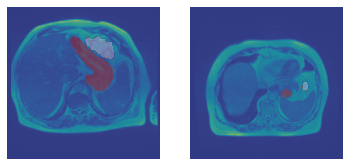

In [15]:
dls.show_batch()

### Code for Inference

In [16]:

import fastai

## run inference on test items provided as a dataframe

def get_predictions(learner:fastai.learner.Learner,test_items,device='cpu'):
    
    test_ds=learner.dls.valid_ds.__class__(test_items)
    test_dl=TfmdDL(test_ds,bs=16)
    model=learner.model.to(device)
    model.eval()
    inputs=[]
    outputs=[]
    labels=[]
    with torch.no_grad():
        for xb,yb in test_dl:
            xb,yb=xb.to(device),yb.to(device)
            xb_3c=xb*torch.ones((1,3,1,1),device=device)
            out=learner.model(xb_3c)
            preds=out.argmax(dim=1)
            ## true input is 3 channel,with 1 channel img being repeated 3rice
            inputs.append(xb_3c)
            labels.append(yb)
            outputs.append(preds)
    
 
    inps,outs,lbls=[torch.cat(tensor_list) for tensor_list in [inputs,outputs,labels]]
    return inps,outs,lbls



## show inputs,predictions and labels
def show_predictions(inputs,outputs,labels):
    line_thickness=inputs.shape[-1]//10
    row_list=[]
    for img,pred_mask,lbl_mask in zip(inputs,outputs,labels):
        
        img=frame_image(np.transpose(img,axes=(1,2,0))/img.max())
        pred_mask=frame_image(mask2display(pred_mask))
        lbl_mask=frame_image(mask2display(lbl_mask))
        row=np.concatenate((img,pred_mask,lbl_mask),axis=1)
        row_list.append(row)
    
    row_array=np.concatenate(row_list,axis=0)
    plt.figure(figsize = (20,20))
    plt.imshow(row_array, interpolation='nearest')






def mask2display(mask,codes={'background':0,'small_bowel':3,'large_bowel':2,'stomach':1},
                 color_codes={0:'lightblue',3:'yellow',2:'green',1:'red'}):
    coloured_masks= [np.array((mask==code).unsqueeze(2))*np.array(matplotlib.colors.to_rgb(color)).reshape((1,1,3)) for code,color in color_codes.items()]
    mask_img=np.stack(coloured_masks,axis=0).sum(axis=0)
    return mask_img
    

## create frame of white pixels (of 10% img width) around an image        
def frame_image(img,width=10):
    H,W,C=img.shape
    framed_img=np.ones((H+2*width,W+2*width,C))
    framed_img[width:-width,width:-width,:]=img
    return framed_img        
    

### CUSTOM Learner equivalent to fastais learner class

In [17]:
#%%writefile 'Pytorch_Learner.py'

import pdb
from tqdm.notebook import tqdm


class PyTorchLearner():
    def __init__(self,model,dls,optim_class,lr,
                 loss_function,metrics=None,device='cuda',**kwargs):
        self.device=device
        self.model=model
        self.dls=dls
        self.lr=lr
        self.optimizer = optim_class(self.model.parameters(),self.lr,**kwargs)
        self.loss_function = loss_function
        self.metrics = metrics
    
    
    @staticmethod
    def update_running_stats(running_val,current_val,num_evals):
        running_val+=(1/(num_evals+1)*(current_val-running_val)).detach().item()
        return running_val

    
    
    def train_epoch(self,train_loader):
        """run one training epoch on train dl return average train loss 
         and optionally run callbacks"""
        self.model.train()
        running_trainloss=0.
      
        for j,(xb,yb) in enumerate(tqdm(train_loader)):
            xb,yb=xb.to(self.device),yb.to(self.device)
            y_pred=self.model(xb)
            trainloss=self.loss_function(y_pred,yb)
            running_trainloss=PyTorchLearner.update_running_stats(running_trainloss,
                                                                     trainloss,j)
            self.optimizer.zero_grad()
            trainloss.backward()
            self.optimizer.step()
        return running_trainloss 
    
     
    def valid_epoch(self,eval_loader):
        """run one evaluation epoch on the eval loader,return valid loss
           and metrics"""
        self.model.eval()
        running_evalloss=0.
        running_metrics=defaultdict(int)
        for k,(xb,yb) in enumerate(tqdm(eval_loader)):
            xb,yb=xb.to(self.device),yb.to(self.device)
            with torch.no_grad():
                y_pred=self.model(xb)
                if self.metrics:
                    for metric_name,metric in self.metrics.items():
                        running_metrics[metric_name]=PyTorchLearner.update_running_stats(running_metrics[metric_name],
                                                                      metric(y_pred,yb),k)
                evalloss=self.loss_function(y_pred,yb)
                running_evalloss=PyTorchLearner.update_running_stats(running_evalloss,
                                                                      evalloss,k)
            return running_evalloss,running_metrics
    
    
    
    
    
    
    def fit(self,n_epochs):
        train_loader,eval_loader=self.dls
        self.model=self.model.to(self.device)
        """ run n_epoch training and validation epochs"""
        log=[]
        for i in tqdm(range(n_epochs)):
            train_loss=self.train_epoch(train_loader)
            eval_loss,metrics_dict=self.valid_epoch(eval_loader)
                
            row={'epoch':i, 'train_loss':train_loss, 'eval_loss': eval_loss}
            row.update(metrics_dict)
            wandb.log(row)
            log.append(row)
            tracking_df=pd.DataFrame(log)
            display(tracking_df)
        
        ## perform cleanup
        self.model=self.model.to('cpu')
        torch.cuda.empty_cache()
        
        return tracking_df
    
    
   

## $\frac{2 * |X \cap Y|}{|X| + |Y|}$

### Metrics and Loss functions

In [18]:
#%%writefile  'loss_and_metrics.py'

from functools import partial

def dice_coeff(pred, targ,smooth=1):
    "Compute dice coeff per class then average b/w predicted and target masks"
    classes=range(pred.shape[1])
    ## get 1_hot pred masks
    pred_mask=pred.argmax(dim=1)
    pred_1hot=torch.stack([pred_mask==c for c in classes],dim=1)
    ## get 1_hot target for each class
    target_1hot=torch.stack([targ==c for c in classes],dim=1)
    ## find intersection (and union) for each class,by summing slong Batch,H,W dims
    intersect_each_class=(pred_1hot*target_1hot).sum(axis=(0,2,3))+smooth
    set_sum_each_class=target_1hot.sum(axis=(0,2,3))+pred_1hot.sum(axis=(0,2,3))+smooth
    ## accumalate class wise intersection/set_sum by taking average across classes
    intersect_by_sum=(intersect_each_class/set_sum_each_class).mean()
    
    return 2*intersect_by_sum


def dice_coeff_foreground(pred, targ,smooth=1):
    "Compute dice coeff per class (excluding background) then average b/w predicted and target masks"
    ## exclude backgroud class=0 from dice calculation
    classes=range(1,pred.shape[1])
    ## get 1_hot pred masks
    pred_mask=pred.argmax(dim=1)
    pred_1hot=torch.stack([pred_mask==c for c in classes],dim=1)
    ## get 1_hot target for each class
    target_1hot=torch.stack([targ==c for c in classes],dim=1)
    ## find intersection (and union) for each class,by summing slong Batch,H,W dims
    intersect_each_class=(pred_1hot*target_1hot).sum(axis=(0,2,3))+smooth
    set_sum_each_class=target_1hot.sum(axis=(0,2,3))+pred_1hot.sum(axis=(0,2,3))+smooth
    ## accumalate class wise intersection/set_sum by taking average across classes
    intersect_by_sum=(intersect_each_class/set_sum_each_class).mean()
    
    return 2*intersect_by_sum



## implementing a smoothen version of the dice coeff, tranforming it to loss =1-dice_coef (to minimize)
def dice_loss(pred, targ,smooth=1):
    "Compute dice coeff b/w predicted and target masks"
    ## softmax instead of argmax to make it differentiable
    classes=range(pred.shape[1])
    pred_mask_soft=F.softmax(pred,dim=1)
    target_1hot=torch.stack([targ==c for c in classes],dim=1)
    ## find intersection (and union) for each class,by summing slong Batch,H,W dims
    intersect_each_class=(pred_mask_soft*target_1hot).sum(axis=(0,2,3))+smooth
    set_sum_each_class=target_1hot.sum(axis=(0,2,3))+pred_mask_soft.sum(axis=(0,2,3))+smooth
    ## accumalate class wise intersection/set_sum by taking average across classes
    intersect_by_sum=(intersect_each_class/set_sum_each_class).mean()
    
    return 1-2*intersect_by_sum

## what pctage of actual pixels of each class are detected
# class_accuracy_metrics={class_name:}

def pixel_accuracy(pred, targ):
    "Compute dice coeff b/w predicted and target masks"
    pred_mask=pred.argmax(dim=1)
    return (pred_mask==targ).float().mean()

def pixel_accuracy_cls(pred, targ,class_num,smooth=1):
    "Compute dice coeff b/w predicted and target masks"
    pred_mask=pred.argmax(dim=1)
    class_mask=(targ==class_num)
    detected_pxl_count=((pred_mask==class_num)*class_mask).sum()
    return (detected_pxl_count+smooth)/(class_mask.sum()+smooth)

#def focal_loss(pred,targ,gamma=0):
 #   """calculate the focal loss between pred and targ """
  #  classes=range(pred.shape[1])  
  #  pred_probs=F.softmax(pred,dim=1)#bs x num_classes x H x W
  #  target_1hot=torch.stack([targ==c for c in classes],dim=1)
  #  pred_likelyhood=(target_1hot*pred_probs).sum(dim=1)           
  #  pdb.set_trace()
  #  loss=-(1-pred_likelyhood)**gamma*torch.log(pred_likelyhood) ## bs X H X W
  #  return loss.mean()


def focal_loss(pred,targ,weights={'background':1.,'small_bowel':16.,'large_bowel':16.,'stomach':16.},
               codes={'background': 0, 'small_bowel': 3, 'large_bowel': 2, 'stomach': 1},gamma=2):
    """calculate the focal loss between pred and targ """
    if weights:
        weights=torch.Tensor([weights[class_name] for class_name in sorted(codes,key=codes.__getitem__)]).to('cuda')
    n_log_likelyhood=CrossEntropyLossFlat(axis=1,reduction='none',weight=weights)(pred,targ)      
    loss=n_log_likelyhood*(1-torch.exp(-n_log_likelyhood))**gamma ## bs X H X W
    return loss.mean()

def weighted_crossentropy_flat(pred,targ,weights={'background':1.,'small_bowel':16.,'large_bowel':16.,'stomach':16.},
               codes={'background': 0, 'small_bowel': 3, 'large_bowel': 2, 'stomach': 1}):
    """calculate the weighted cross_entropy between pred and targ """
    if weights:
        weights=torch.Tensor([weights[class_name] for class_name in sorted(codes,key=codes.__getitem__)]).to('cuda')
    return CrossEntropyLossFlat(axis=1,weight=weights)(pred,targ)      
    
   

def segmentation_cross_entropy_loss(img_out,mask):
    return F.cross_entropy(img_out.flatten(start_dim=2),mask.flatten(start_dim=1))
    


In [19]:
## deining metrics+ losses to train

metrics={'dice_coeff_fg':dice_coeff_foreground,'pixel_accuracy':pixel_accuracy,'cross_entropy':CrossEntropyLossFlat(axis=1)}
class_accus={class_name:partial(pixel_accuracy_cls,class_num=class_num) 
             for class_name,class_num in ds.codes.items()}
metrics.update(class_accus)
metrics_list=list(metrics.values())

In [ ]:
import datetime
'model_{}'.format(datetime.datetime.now())
## distinguish model saves by datetime when training starts

In [24]:
learn_fastai=unet_learner(dls,resnet34,n_out=4,loss_func=focal_loss,metrics=metrics_list,lr=4.2e-4,cbs=[SaveModelCallback(monitor='dice_coeff_foreground',
                                                                                                     fname='model_{}'.format(datetime.datetime.now())),
                                                                                                        save_training_progress_cb])

In [25]:
learn_fastai.fit(7)

epoch,train_loss,valid_loss,dice_coeff_foreground,pixel_accuracy,None,pixel_accuracy_cls,pixel_accuracy_cls,pixel_accuracy_cls,pixel_accuracy_cls,time
0,6.819589,4.894317,0.504193,0.952858,1.353431,0.961750,0.773010,0.815116,0.558861,48:03
1,3.576029,3.183226,0.607838,0.971856,0.402510,0.982330,0.631747,0.895428,0.545349,34:39
2,2.020074,1.894007,0.554371,0.961971,0.483733,0.969807,0.640989,0.888280,0.741508,35:00
3,1.496395,1.504364,0.542197,0.946287,0.768665,0.950902,0.909317,0.784151,0.794152,34:30
4,0.975801,0.587341,0.691812,0.976410,0.148860,0.981822,0.874810,0.893949,0.716199,35:24
5,0.766816,0.932444,0.683506,0.974513,0.154632,0.979766,0.886605,0.921734,0.667883,35:17
6,0.639469,1.028086,0.736477,0.980787,0.139808,0.986502,0.960923,0.840300,0.676582,37:45


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


D:\Anaconda3\envs\fastai2022\lib\site-packages\fastai\callback\core.py:69: UserWarning: You are shadowing an attribute (model) that exists in the learner. Use `self.learn.model` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Better model found at epoch 0 with dice_coeff_foreground value: 0.5041932463645935.
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing is

D:\Anaconda3\envs\fastai2022\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Better model found at epoch 4 with dice_coeff_foreground value: 0.69181227684021.
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn'

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

### Save Model and Learner

In [79]:
import datetime

def save_learner(learner,learner_filename='learner',save_pytorch_model=True):
    """save Fatsai learner,optionally with model in pytorch format with state dict"""
    ## root folder for all model wts/learner object saves (fastai creates this by default)
   
    ## save in subfolders indexed by savetime
    date,time='{}'.format(datetime.datetime.now()).split(' ')
    ## swap : with _
    time='_'.join(time.split(':'))
    date_time='_'.join([date,time])
    subfolder=Path('models')/Path(date_time)
    
    
   
    subfolder.mkdir(exist_ok=True)
    
    
    ## give a descriptive learner_filename. Ideally with train config (wandb.config) used to train
    
    model_filename=Path('_'.join([learner_filename,'model.pt']))
    learner_filename=Path(learner_filename)
    learner_path,model_path=[Path(date_time)/filename for filename in [learner_filename,model_filename]]
    
    ## saving learner for inference
    learner.save(file= learner_path)
    ## saving model (Ws and bs) the state dict with ley variable names and values tensors (params)
    if save_pytorch_model:
        torch.save(learner.model.state_dict(),Path('models')/model_path)
        
    return Path('models')/learner_path,Path('models')/model_path
        
    
    

In [80]:
save_learner(learn_fastai)

(Path('models/2022-09-11_14_19_16.157819/learner'),
 Path('models/2022-09-11_14_19_16.157819/learner_model.pt'))

### USING CUSTOM LEARNER CLASS

In [ ]:
def log_metric(self):
    if(self.iter%50==0):
        dice=dice_coeff_foreground(self.model(self.xb),self.yb)
        wandb.log(dice)

In [233]:
model=create_unet_model(resnet34,n_out=4,n_in=1,img_size=(224,224))
learn=PyTorchLearner(model=model,dls=dls,optim_class=Adam,lr=4e-4,loss_function=focal_loss,device='cuda',
                     metrics=metrics)

In [18]:
learn.fit(5)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

,epoch,train_loss,eval_loss,dice_coeff,pixel_accuracy,cross_entropy,background,small_bowel,large_bowel,stomach
0,0,7.373728,0.393545,0.295359,0.964124,0.458556,0.9971,0.0625,0.025914,0.033049


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

,epoch,train_loss,eval_loss,dice_coeff,pixel_accuracy,cross_entropy,background,small_bowel,large_bowel,stomach
0,0,7.373728,0.393545,0.295359,0.964124,0.458556,0.997100,0.062500,0.025914,0.033049
1,1,0.272448,0.365715,0.347332,0.949216,0.431368,0.975157,0.220414,0.444955,0.000178


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

,epoch,train_loss,eval_loss,dice_coeff,pixel_accuracy,cross_entropy,background,small_bowel,large_bowel,stomach
0,0,7.373728,0.393545,0.295359,0.964124,0.458556,0.997100,0.062500,0.025914,0.033049
1,1,0.272448,0.365715,0.347332,0.949216,0.431368,0.975157,0.220414,0.444955,0.000178
2,2,0.321527,0.246099,0.403714,0.968648,0.290623,0.996517,0.376479,0.278258,0.001066


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

,epoch,train_loss,eval_loss,dice_coeff,pixel_accuracy,cross_entropy,background,small_bowel,large_bowel,stomach
0,0,7.373728,0.393545,0.295359,0.964124,0.458556,0.997100,0.062500,0.025914,0.033049
1,1,0.272448,0.365715,0.347332,0.949216,0.431368,0.975157,0.220414,0.444955,0.000178
2,2,0.321527,0.246099,0.403714,0.968648,0.290623,0.996517,0.376479,0.278258,0.001066
3,3,0.161435,0.142907,0.451696,0.965970,0.182525,0.991311,0.389053,0.225878,0.213220


  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

,epoch,train_loss,eval_loss,dice_coeff,pixel_accuracy,cross_entropy,background,small_bowel,large_bowel,stomach
0,0,7.373728,0.393545,0.295359,0.964124,0.458556,0.997100,0.062500,0.025914,0.033049
1,1,0.272448,0.365715,0.347332,0.949216,0.431368,0.975157,0.220414,0.444955,0.000178
2,2,0.321527,0.246099,0.403714,0.968648,0.290623,0.996517,0.376479,0.278258,0.001066
3,3,0.161435,0.142907,0.451696,0.965970,0.182525,0.991311,0.389053,0.225878,0.213220
4,4,0.139929,0.073146,0.495830,0.972352,0.122635,0.994196,0.331731,0.630950,0.105721


,epoch,train_loss,eval_loss,dice_coeff,pixel_accuracy,cross_entropy,background,small_bowel,large_bowel,stomach
0,0,7.373728,0.393545,0.295359,0.964124,0.458556,0.997100,0.062500,0.025914,0.033049
1,1,0.272448,0.365715,0.347332,0.949216,0.431368,0.975157,0.220414,0.444955,0.000178
2,2,0.321527,0.246099,0.403714,0.968648,0.290623,0.996517,0.376479,0.278258,0.001066
3,3,0.161435,0.142907,0.451696,0.965970,0.182525,0.991311,0.389053,0.225878,0.213220
4,4,0.139929,0.073146,0.495830,0.972352,0.122635,0.994196,0.331731,0.630950,0.105721


#### WANDB HYPERPARAM SEARCH n LOGGIN

In [37]:

hyperparameters = {
  "learning_rate": 0.001,
  "epochs": 10,
  "batch_size": 16,
  'loss_fn': focal_loss ,
  'arch':resnet34 
}

In [ ]:
ds=RLE_SegmentationDataset(all_imgs_df[:1000])
ds_fg=ds.foreground_only()
ds_fg.img_paths_df

In [40]:
metrics={'dice_coeff':dice_coeff,'pixel_accuracy':pixel_accuracy,'cross_entropy':CrossEntropyLossFlat(axis=1)}
class_accus={class_name:partial(pixel_accuracy_cls,class_num=class_num) 
             for class_name,class_num in ds.codes.items()}
metrics.update(class_accus)

In [53]:
def run_frm_config(hyperparameters,learner,dset, metrics):
    
    with wandb.init(project="test-project", entity="ai_in_pathology",config=hyperparameters):
        config=hyperparameters
        ds_train,ds_test=dset.train_test_split()

        dls=SegmentationDataLoaders.from_dsets(ds_train,ds_test,
                                       codes=np.array(list(ds_train.codes.keys())),bs=config['batch_size'],device='cuda')
        
    
        model=create_unet_model(config['arch'],n_out=4,n_in=1,img_size=(224,224))
        wandb.watch(model,criterion=config['loss_fn'],log_freq=10)
        learn=learner(model=model,dls=dls,optim_class=Adam,lr=config['learning_rate'],loss_function=config['loss_fn'],device='cuda',
                     metrics=metrics)
    
        learn.fit(config['epochs'])
    return learn 

#### Setting up Sweep for hyperparameter tuning

In [26]:
%%writefile 'wandb_sweep_config.py'

sweep_config = {
    'method': 'bayes'
    }
metric = {
    'name': 'dice_coeff',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric


parameters_dict={}

model_args_dict={ 'arch': {
        'values': ['resnet18','resnet34','resnet50','resnet101','resnet152']},
        'self_attention':{'values':[True,False]}
}

loss_args_dict={
    
     'loss_fn': {
        'values': ['focal_loss','wted_crossentropy']},
    
    'small_bowel_wt': {
        'distribution': 'q_log_uniform_values',
        'q': 10,
        'min': 10,
        'max': 1000
      },
    
    'stomach_wt': {
        'distribution': 'q_log_uniform_values',
        'q': 10,
        'min': 10,
        'max': 1000
      },
    'large_bowel_wt': {
        'distribution': 'q_log_uniform_values',
        'q': 10,
        'min': 10,
        'max': 1000
      },
    'background_wt':{'values':[1.]}
    }

    
optimizer_args_dict={ 'learning_rate': {
        'distribution': 'q_log_uniform_values',
        'q': 10,
        'min': 1e-4,
        'max': 100
      }
         }

dataloader_args_dict={
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms 
        'distribution': 'q_log_uniform_values',
        'q': 2,
        'min': 8,
        'max': 32,
      }


}

epochs_dict={'epochs': {
        'values': [5,10,20]}}    
    
    
parameters_dict.update(model_args_dict)
parameters_dict.update(loss_args_dict)
parameters_dict.update(optimizer_args_dict)
parameters_dict.update(epochs_dict)
parameters_dict.update(dataloader_args_dict)
sweep_config['parameters'] = parameters_dict
sweep_id=wandb.sweep(sweep_config)


arch_dict={'resnet18':resnet18,'resnet34':resnet34,'resnet50':resnet50,'resnet101':resnet101,'resnet152':resnet152}
loss_fns_dict={'focal_loss':focal_loss,'wted_crossentropy':weighted_crossentropy_flat}

Writing wandb_sweep_config.py


In [80]:
ds_train,ds_test=ds_fg.train_test_split()


def run_sweep(learner=PyTorchLearner,ds_train=ds_train,ds_test=ds_test, metrics=metrics):
    
    with wandb.init(project="test-project", entity="ai_in_pathology"):
        config=wandb.config
        dls=SegmentationDataLoaders.from_dsets(ds_train,ds_test,
                                       codes=np.array(list(ds_train.codes.keys())),bs=config['batch_size'],device='cuda')
        
        ## setting up model from config
        model=create_unet_model(arch=arch_dict[config['arch']],n_out=4,n_in=1,img_size=(224,224),
                                self_attention=config['self_attention'])
        
        wandb.watch(model,criterion=config['loss_fn'],log_freq=10)
        
        ## setting up loss function from config,including class weights
        class_loss_weights={class_name:config['_'.join((class_name,'wt'))] for class_name in ds_train.codes}
        loss_fn=loss_fns_dict[config['loss_fn']]
        wted_loss_fn=partial(loss_fn,weights=class_loss_weights)
        
        learn=learner(model=model,dls=dls,optim_class=Adam,lr=config['learning_rate'],loss_function=wted_loss_fn,device='cuda',
                     metrics=metrics)
    
        learn.fit(config['epochs'])
    return learn



In [81]:
count = 1 # number of runs to execute
wandb.agent(sweep_id, function=run_sweep, count=count)

wandb: Agent Starting Run: 5zlxorw9 with config:
wandb: 	arch: resnet101
wandb: 	background_wt: 1
wandb: 	batch_size: 24
wandb: 	epochs: 10
wandb: 	large_bowel_wt: 110
wandb: 	learning_rate: 0
wandb: 	loss_fn: wted_crossentropy
wandb: 	self_attention: False
wandb: 	small_bowel_wt: 60
wandb: 	stomach_wt: 80
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

Run 5zlxorw9 errored: RuntimeError('CUDA out of memory. Tried to allocate 222.00 MiB (GPU 0; 6.00 GiB total capacity; 4.95 GiB already allocated; 0 bytes free; 5.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run 5zlxorw9 errored: RuntimeError('CUDA out of memory. Tried to allocate 222.00 MiB (GPU 0; 6.00 GiB total capacity; 4.95 GiB already allocated; 0 bytes free; 5.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')


In [54]:
learn=run_frm_config(hyperparameters=hyperparameters,learner=PyTorchLearner,dset=ds_fg,metrics=metrics)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


D:\Anaconda3\envs\fastai2022\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
D:\Anaconda3\envs\fastai2022\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 298.00 MiB (GPU 0; 6.00 GiB total capacity; 4.51 GiB already allocated; 0 bytes free; 5.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF